# Phrase Modelling Part I - Building Corpora

## Set path

In [326]:
import os
path = os.getcwd()[:-16]
path

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

import time

## Read and process document

Read data

In [327]:
import pandas as pd

news = pd.read_csv(path + '/emfdscore/emfd_processed.csv')

Process data

In [328]:
# 1. Z-transform mf-probability and mf-sentiment scores

def standardize(df):
    probabilities = ['care_p', 'fairness_p', 'loyalty_p', 'authority_p','sanctity_p']
    sentiments = ['care_sent', 'fairness_sent', 'loyalty_sent','authority_sent','sanctity_sent']
    
    for p in probabilities:
        df[p] = (df[p] - df[p].mean()) / df[p].std()
    for s in sentiments:
        df[s] = (df[s] - df[s].mean()) / df[s].std()
        
    return df

In [329]:
# 2. Multiply transformed mf-probability * mf-sentiment

def multiply(df):
    foundations = ['care','fairness','loyalty','authority','sanctity']
    
    for f in foundations:
        df[f+'_prod'] = df[f+'_p'] * df[f+'_sent']
    
    return df

In [330]:
# nested functions, putting it all together
processed_news = multiply(standardize(news))

Generate ramdom sample from 10% of the data

In [342]:
n = int(0.1*len(processed_news))
sample = processed_news.sample(n=n, random_state=0)

In [344]:
len(sample)

69917

In [346]:
sample_titles_list = sample.title.tolist()

In [352]:
sample_titles_list[:10]

['A "Pro-Life Hero"? Trump Becomes First President To Speak At \'March For Life\'',
 "USS Theodore Roosevelt's entire crew has been tested for coronavirus; over 800 positive, officials say",
 'COVID-19 Deaths Explode In Russia, Mexico And Brazil As Global Cases Top 6.5 Million: Live Updates',
 'Beware—Android Phones Crippled By Dangerous New Image Shared On Social Media',
 "Israel Will Vote Sunday To Annex West Bank Lands Delineated In Trump's 'Peace Plan'",
 'Indonesia study warns Ramadan exodus would fuel coronavirus',
 'Trump signs spending bills, avoiding government shutdown',
 "Trump lawyers' weak start opens the door to devastating questions",
 'Ex-NASA administrator James Beggs dead at 94',
 "Bills' Josh Allen says 57 Buffalo police officers who resigned don't deserve to be part of emergency unit"]

Create dictionary of titles

In [7]:
titles_dict = {
    'care':processed_news.where(processed_news.care_prod>0).dropna().title.tolist(),
    'harm':processed_news.where(processed_news.care_prod<0).dropna().title.tolist(),
                      
    'fairness':processed_news.where(processed_news.fairness_prod>0).dropna().title.tolist(),
    'cheating':processed_news.where(processed_news.fairness_prod<0).dropna().title.tolist(),
                      
    'loyalty':processed_news.where(processed_news.loyalty_prod>0).dropna().title.tolist(),
    'betrayal':processed_news.where(processed_news.loyalty_prod<0).dropna().title.tolist(),
                      
    'authority':processed_news.where(processed_news.authority_prod>0).dropna().title.tolist(),
    'subversion':processed_news.where(processed_news.authority_prod<0).dropna().title.tolist(),
                      
    'sanctity':processed_news.where(processed_news.sanctity_prod>0).dropna().title.tolist(),
    'degradation':processed_news.where(processed_news.sanctity_prod<0).dropna().title.tolist()
}

## Define Data

To create a list of titles within each foundation, identify the relevant foundation as the `foundation` variable.

In [8]:
foundation = "cheating"

len(titles_dict[foundation])

368743

In [9]:
data = titles_dict[foundation] # list of strings

In [10]:
data[:10]

['Trent Williams, Redskins OT, says he had cancer, team misdiagnosed it',
 'Pinterest Stock Plunges on Sales Miss',
 'Arista Networks Stock Plunges as Earnings Outlook Disappoints',
 "Heidi Klum's 2019 Halloween costume transformation is scary good",
 'The Epic Macklowe Divorce: How A Famous $1 Billion Art Collection Got Snagged In Court',
 'Texas man convicted of fatally stabbing stepmother who danced after Cowboys victory',
 'Was David Montgomery over Jordan Howard a win for Chicago Bears?',
 'A Top United Auto Workers Officer Faces Embezzlement Charges',
 'Trump, Lifelong New Yorker, Declares Himself a Resident of Florida',
 "Three very different books explore California's destiny"]

## Build corpus from selected data

1. Preprocess words in sentences (remove punctuation & stopwords)
2. Build bigrams and trigrams
3. Create dictionary using bag-of-words approach (assign IDs to words)
4. Create corpus as set of dictionary-defined vectors, each representing a document within the dataset

In [347]:
from gensim import corpora, models, utils

### Simple preprocess into words

In [348]:
def sent_to_words(titles):
    for title in titles:
        yield(utils.simple_preprocess(str(title), deacc=True))  # deacc=True removes punctuations

words = list(sent_to_words(sample_titles_list)) # format: list of list

In [350]:
words[:3]

[['pro',
  'life',
  'hero',
  'trump',
  'becomes',
  'first',
  'president',
  'to',
  'speak',
  'at',
  'march',
  'for',
  'life'],
 ['uss',
  'theodore',
  'roosevelt',
  'entire',
  'crew',
  'has',
  'been',
  'tested',
  'for',
  'coronavirus',
  'over',
  'positive',
  'officials',
  'say'],
 ['covid',
  'deaths',
  'explode',
  'in',
  'russia',
  'mexico',
  'and',
  'brazil',
  'as',
  'global',
  'cases',
  'top',
  'million',
  'live',
  'updates']]

### Remove stopwords

In [351]:
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
nlp = en_core_web_sm.load()

def stop_remove(texts):
    ls=[]
    for nested_list in texts:
        filtered_words = []
        for word in nested_list:
            lexeme = nlp.vocab[str(word)]
            if lexeme.is_stop == False:
                filtered_words.append(word)
        ls.append(filtered_words)
    return ls

words_nostops = stop_remove(words) # format: list of list

In [354]:
words_nostops[:3]

[['pro', 'life', 'hero', 'trump', 'president', 'speak', 'march', 'life'],
 ['uss',
  'theodore',
  'roosevelt',
  'entire',
  'crew',
  'tested',
  'coronavirus',
  'positive',
  'officials'],
 ['covid',
  'deaths',
  'explode',
  'russia',
  'mexico',
  'brazil',
  'global',
  'cases',
  'million',
  'live',
  'updates']]

### Remove words that appear only once

In [355]:
from collections import defaultdict

def filter_low_freq(texts):
    count1 = sum([len(ele) for ele in texts]) 

    # remove words that appear only once
    frequency = defaultdict(int)
    for text in texts:
        for token in text:
            frequency[token] += 1
    texts = [[token for token in text if frequency[token] > 1] for text in texts]

    count2 = sum([len(ele) for ele in texts]) 
    
    print('Before removal: %d' % count1)
    print('After removal: %d' % count2)
    
    return texts

words_filter = filter_low_freq(words_nostops)

Before removal: 543108
After removal: 529285


### Build bigram and trigram models

In [356]:
start = time.time()

bigram = models.Phrases(words_filter, min_count=5, threshold=100)
trigram = models.Phrases(bigram[words_filter], threshold=100)  

bigram_mod = models.phrases.Phraser(bigram)
trigram_mod = models.phrases.Phraser(trigram)

end = time.time()
print("Elapsed:", end - start, 'seconds')

Elapsed: 5.930211782455444 seconds


Define functions for trigrams and lemmatization

In [357]:
start = time.time()

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

words_trigrams = make_trigrams(words_filter)

end = time.time()
print("Elapsed:", end - start, 'seconds')

Elapsed: 1.6169397830963135 seconds


In [358]:
start = time.time()
df = pd.DataFrame(words_trigrams)
end = time.time()
print("Elapsed:", end - start, 'seconds')

Elapsed: 0.16161203384399414 seconds


In [359]:
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,pro,life,hero,trump,president,speak,march,life,None,None,None,None,None,None,None,None,None,None,None,None
1,uss_theodore_roosevelt,entire,crew,tested,coronavirus,positive,officials,None,None,None,None,None,None,None,None,None,None,None,None,None
2,covid,deaths,explode,russia,mexico,brazil,global,cases,million,live_updates,None,None,None,None,None,None,None,None,None,None
3,beware,android,phones,crippled,dangerous,new,image,shared,social_media,None,None,None,None,None,None,None,None,None,None,None
4,israel,vote,sunday,annex,west,bank,lands,trump,peace,plan,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69912,editorial,pg,convicted,killer,allowed,kill,None,None,None,None,None,None,None,None,None,None,None,None,None,None
69913,coronavirus,spring,cleaning,surge,leaves,residential,garbage,cans,None,None,None,None,None,None,None,None,None,None,None,None
69914,staffer,tests_positive,coronavirus,closes,dc,office,None,None,None,None,None,None,None,None,None,None,None,None,None,None
69915,federal,student_loan,repayment,find,best,plan,None,None,None,None,None,None,None,None,None,None,None,None,None,None


### Create dictionary & corpus from lemmatized trigrams

Create dictionary

In [360]:
id2word = corpora.Dictionary(words_trigrams)

Plot the frequency of number of document appearances

<module 'matplotlib.pyplot' from '/usr/local/miniconda3/envs/nlp/lib/python3.8/site-packages/matplotlib/pyplot.py'>

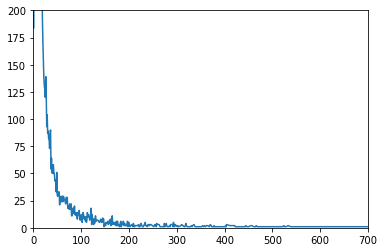

In [368]:
from collections import Counter

# get list of how many documents the word appeared in
doc_occurences = sorted(id2word.dfs.values()) 

# get frequency of each appearance count (e.g., there was 5000 words that appeared in a document once)
freq_doc_occur = Counter(doc_occurences).items() 

# x=number of document appearances, y=how many words have that number of document appearances
x, y = zip(*freq_doc_occur) 

import matplotlib.pyplot as plt

plt.plot(x,y,)
plt.ylim([0, 200])
plt.xlim([0, 700])
plt

View trigrams and their document occurrence rates

In [370]:
ls=[]
for key, value in id2word.dfs.items():
    if value < 100 :
        ls.append([key,id2word[key], value])

pd.DataFrame(ls, columns=['ID','trigrams','doc_occur']).sort_values(by='doc_occur', ascending=False).head(50)

,ID,trigrams,doc_occur
192,346,declares,99
1200,1789,road,99
2824,3651,finally,99
1714,2422,delivery,99
959,1477,buttigieg,99
966,1486,facing,99
3080,3929,south_carolina,99
933,1444,picks,99
1946,2690,blasts,98
260,461,cloud,98


Filter trigrams from dictionary

In [371]:
path = os.getcwd() + '/tmp_filter/'

# Create Dictionary
id2word = corpora.Dictionary(words_trigrams)
print('Number of unique tokens in dictionary: %d' % len(id2word))

# Filter out words that occur in less than 100 documents
#id2word.filter_extremes(no_below=100)
print('Number of unique tokens after filtering: %d' % len(id2word))

# Filter out specific words
#id2word.filter_tokens(bad_ids= 
#                      (
#                          id2word.token2id['coronavirus'], 
#                          id2word.token2id['covid'],
#                          id2word.token2id['pandemic'],
                          #id2word.token2id['update'],
                          #id2word.token2id['cases'],
                          #id2word.token2id['virus'],
                          #id2word.token2id['china'],
                          #id2word.token2id['trump'],
                          #id2word.token2id['says'],
                          #id2word.token2id['new'],
#                      ))
#print('Number of unique tokens after filtering: %d' % len(id2word))

# Save to tmp folder
id2word.save(path + '{}_dict_filter.dict'.format(foundation)) 

Number of unique tokens in dictionary: 22688
Number of unique tokens after filtering: 22688


Create corpus

In [23]:
start = time.time()
path = os.getcwd() + '/tmp_filter/'

# Create Corpus
texts = words_trigrams

# Bag-of-words representation of the documents.
corpus = [id2word.doc2bow(text) for text in texts]
corpora.MmCorpus.serialize(path + '{}_corpus_filter.mm'.format(foundation), corpus) # Save to tmp folder

end = time.time()
print("Elapsed:", end - start, 'seconds')

Elapsed: 3.8277587890625 seconds


In [24]:
print('Foundation: {}'.format(foundation))
print('Number of unique tokens in dictionary: %d' % len(id2word))
print('Number of documents in corpus: %d' % len(corpus))

Foundation: cheating
Number of unique tokens in dictionary: 4136
Number of documents in corpus: 368743


Checking the common words across all four dictionaries

In [25]:
path = os.getcwd() + '/tmp/'

sanctity_dict = corpora.Dictionary.load(path + 'sanctity_dict.dict')
degradation_dict = corpora.Dictionary.load(path + 'degradation_dict.dict')
fairness_dict = corpora.Dictionary.load(path + 'fairness_dict.dict')
cheating_dict = corpora.Dictionary.load(path + 'cheating_dict.dict')

In [26]:
Counter(sorted(sanctity_dict.dfs.values()))

Counter({1: 20899,
         2: 8096,
         3: 4657,
         4: 3220,
         5: 2450,
         6: 2854,
         7: 2448,
         8: 1964,
         9: 1503,
         10: 1291,
         11: 1187,
         12: 1043,
         13: 925,
         14: 808,
         15: 715,
         16: 597,
         17: 557,
         18: 503,
         19: 470,
         20: 399,
         21: 354,
         22: 367,
         23: 345,
         24: 319,
         25: 265,
         26: 246,
         27: 277,
         28: 248,
         29: 212,
         30: 244,
         31: 206,
         32: 204,
         33: 178,
         34: 182,
         35: 138,
         36: 136,
         37: 155,
         38: 137,
         39: 138,
         40: 116,
         41: 120,
         42: 122,
         43: 108,
         44: 126,
         45: 110,
         46: 92,
         47: 116,
         48: 97,
         49: 85,
         50: 84,
         51: 76,
         52: 85,
         53: 98,
         54: 66,
         55: 61,
         56: 78

In [27]:
def make_doc_occur_df(dictionary, foundation):
    ls=[]
    for key, value in dictionary.dfs.items():
        if value > 1000 :
            ls.append([key,dictionary[key], value])
    df = pd.DataFrame(ls, columns=['ID','trigrams','doc_occur']).sort_values(by='doc_occur', ascending=False).head(50)
    df['foundation'] = foundation
    return df    

In [28]:
df = pd.concat([make_doc_occur_df(degradation_dict, "degradation"),
           make_doc_occur_df(sanctity_dict, "sanctity"), 
           make_doc_occur_df(fairness_dict, "fairness"), 
           make_doc_occur_df(cheating_dict, "cheating")])

In [29]:
df.groupby('foundation').head(5)

,ID,trigrams,doc_occur,foundation
409,44765,coronavirus,52844,degradation
16,59,trump,29618,degradation
17,57,new,25973,degradation
0,4,says,20921,degradation
127,526,china,14722,degradation
258,42851,coronavirus,41454,sanctity
17,94,trump,22215,sanctity
32,197,new,18279,sanctity
16,93,says,14733,sanctity
45,244,china,8826,sanctity
